In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
from catboost import CatBoostClassifier


from sklearn.model_selection import train_test_split, GridSearchCV, KFold, \
RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier, GradientBoostingClassifier, RandomForestClassifier

from lightgbm import LGBMClassifier

import optuna

In [222]:
RANDOM = 1985

In [113]:
train = pd.read_csv('train.csv', index_col=0, header=0)
test = pd.read_csv('test.csv', index_col=0, header=0)

In [114]:
train.shape

(165034, 13)

In [115]:
test_index = test.index

In [116]:
train.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [117]:
train.tail()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
165029,15667085,Meng,667,Spain,Female,33.0,2,0.0,1,1.0,1.0,131834.75,0
165030,15665521,Okechukwu,792,France,Male,35.0,3,0.0,1,0.0,0.0,131834.45,0
165031,15664752,Hsia,565,France,Male,31.0,5,0.0,1,1.0,1.0,127429.56,0
165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.0,1,0.0,1.0,71173.03,0
165033,15732798,Ulyanov,850,France,Male,31.0,1,0.0,1,1.0,0.0,61581.79,1


In [118]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 165034 entries, 0 to 165033
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       165034 non-null  int64  
 1   Surname          165034 non-null  object 
 2   CreditScore      165034 non-null  int64  
 3   Geography        165034 non-null  object 
 4   Gender           165034 non-null  object 
 5   Age              165034 non-null  float64
 6   Tenure           165034 non-null  int64  
 7   Balance          165034 non-null  float64
 8   NumOfProducts    165034 non-null  int64  
 9   HasCrCard        165034 non-null  float64
 10  IsActiveMember   165034 non-null  float64
 11  EstimatedSalary  165034 non-null  float64
 12  Exited           165034 non-null  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 17.6+ MB


In [119]:
train['Exited'].unique()

array([0, 1], dtype=int64)

In [120]:
train_digits = train.select_dtypes(include=['int64', 'float64'])

In [121]:
train_digits.info()

<class 'pandas.core.frame.DataFrame'>
Index: 165034 entries, 0 to 165033
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       165034 non-null  int64  
 1   CreditScore      165034 non-null  int64  
 2   Age              165034 non-null  float64
 3   Tenure           165034 non-null  int64  
 4   Balance          165034 non-null  float64
 5   NumOfProducts    165034 non-null  int64  
 6   HasCrCard        165034 non-null  float64
 7   IsActiveMember   165034 non-null  float64
 8   EstimatedSalary  165034 non-null  float64
 9   Exited           165034 non-null  int64  
dtypes: float64(5), int64(5)
memory usage: 13.9 MB


<Axes: >

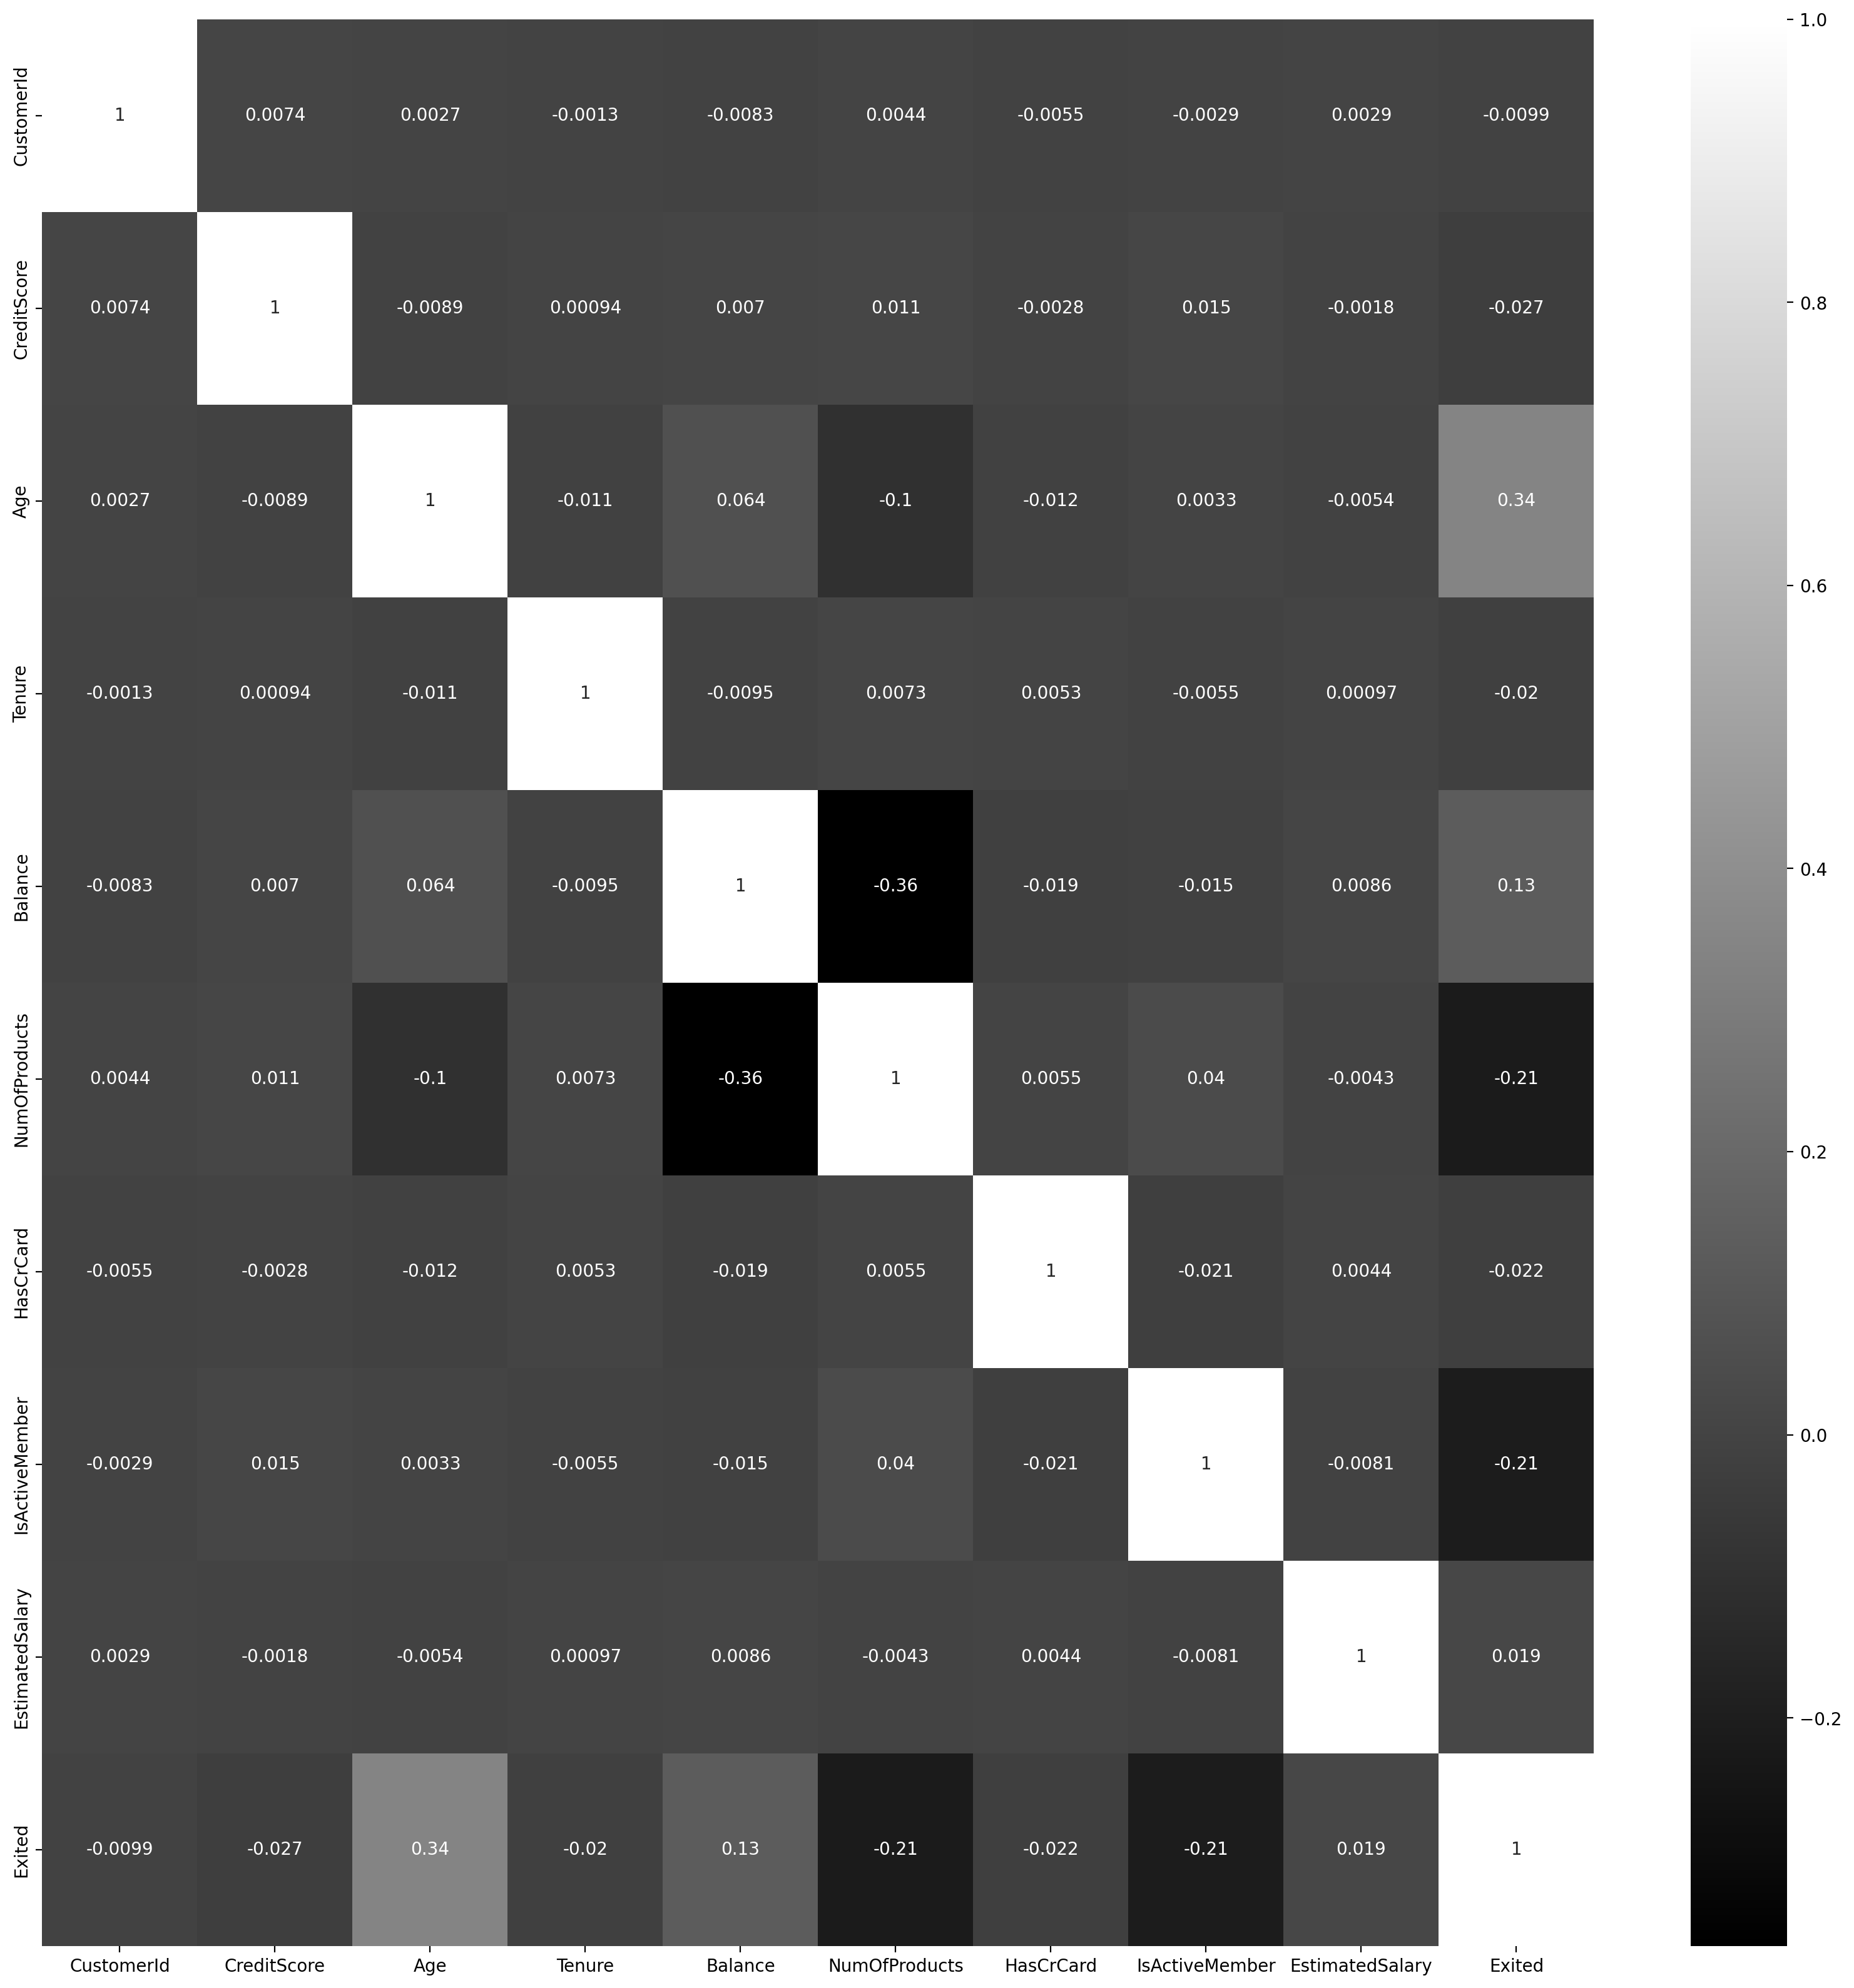

In [122]:
plt.figure(figsize=(20, 20), dpi=200)
sns.heatmap(train_digits.corr(), annot=True, cmap='gray')

In [123]:
sns.set_palette('bright')

In [124]:
pd.DataFrame(train_digits.corr()['Exited'].sort_values(ascending=False)[1:])

,Exited
Age,0.340768
Balance,0.129743
EstimatedSalary,0.018827
CustomerId,-0.009947
Tenure,-0.019565
HasCrCard,-0.022141
CreditScore,-0.027383
IsActiveMember,-0.210237
NumOfProducts,-0.214554


In [125]:
train['HasCrCard'].unique()

array([1., 0.])

In [126]:
train['IsActiveMember'].unique()

array([0., 1.])

In [127]:
train['NumOfProducts'].unique()

array([2, 1, 3, 4], dtype=int64)

<Axes: xlabel='Age', ylabel='Density'>

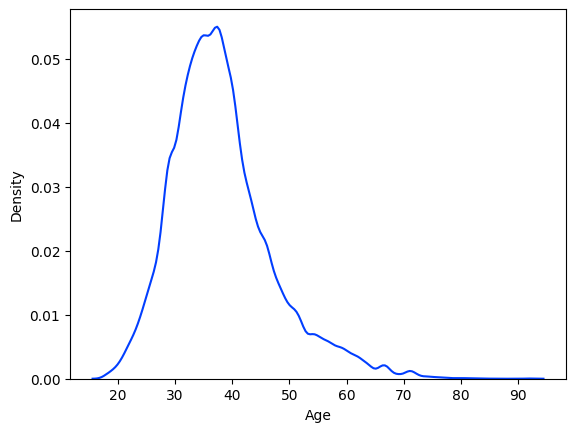

In [128]:
sns.kdeplot(train, x='Age')

In [129]:
print(train['Age'].kurt(),
     train['Age'].skew())

1.532405753512045 0.9680627926499467


<Axes: ylabel='Age'>

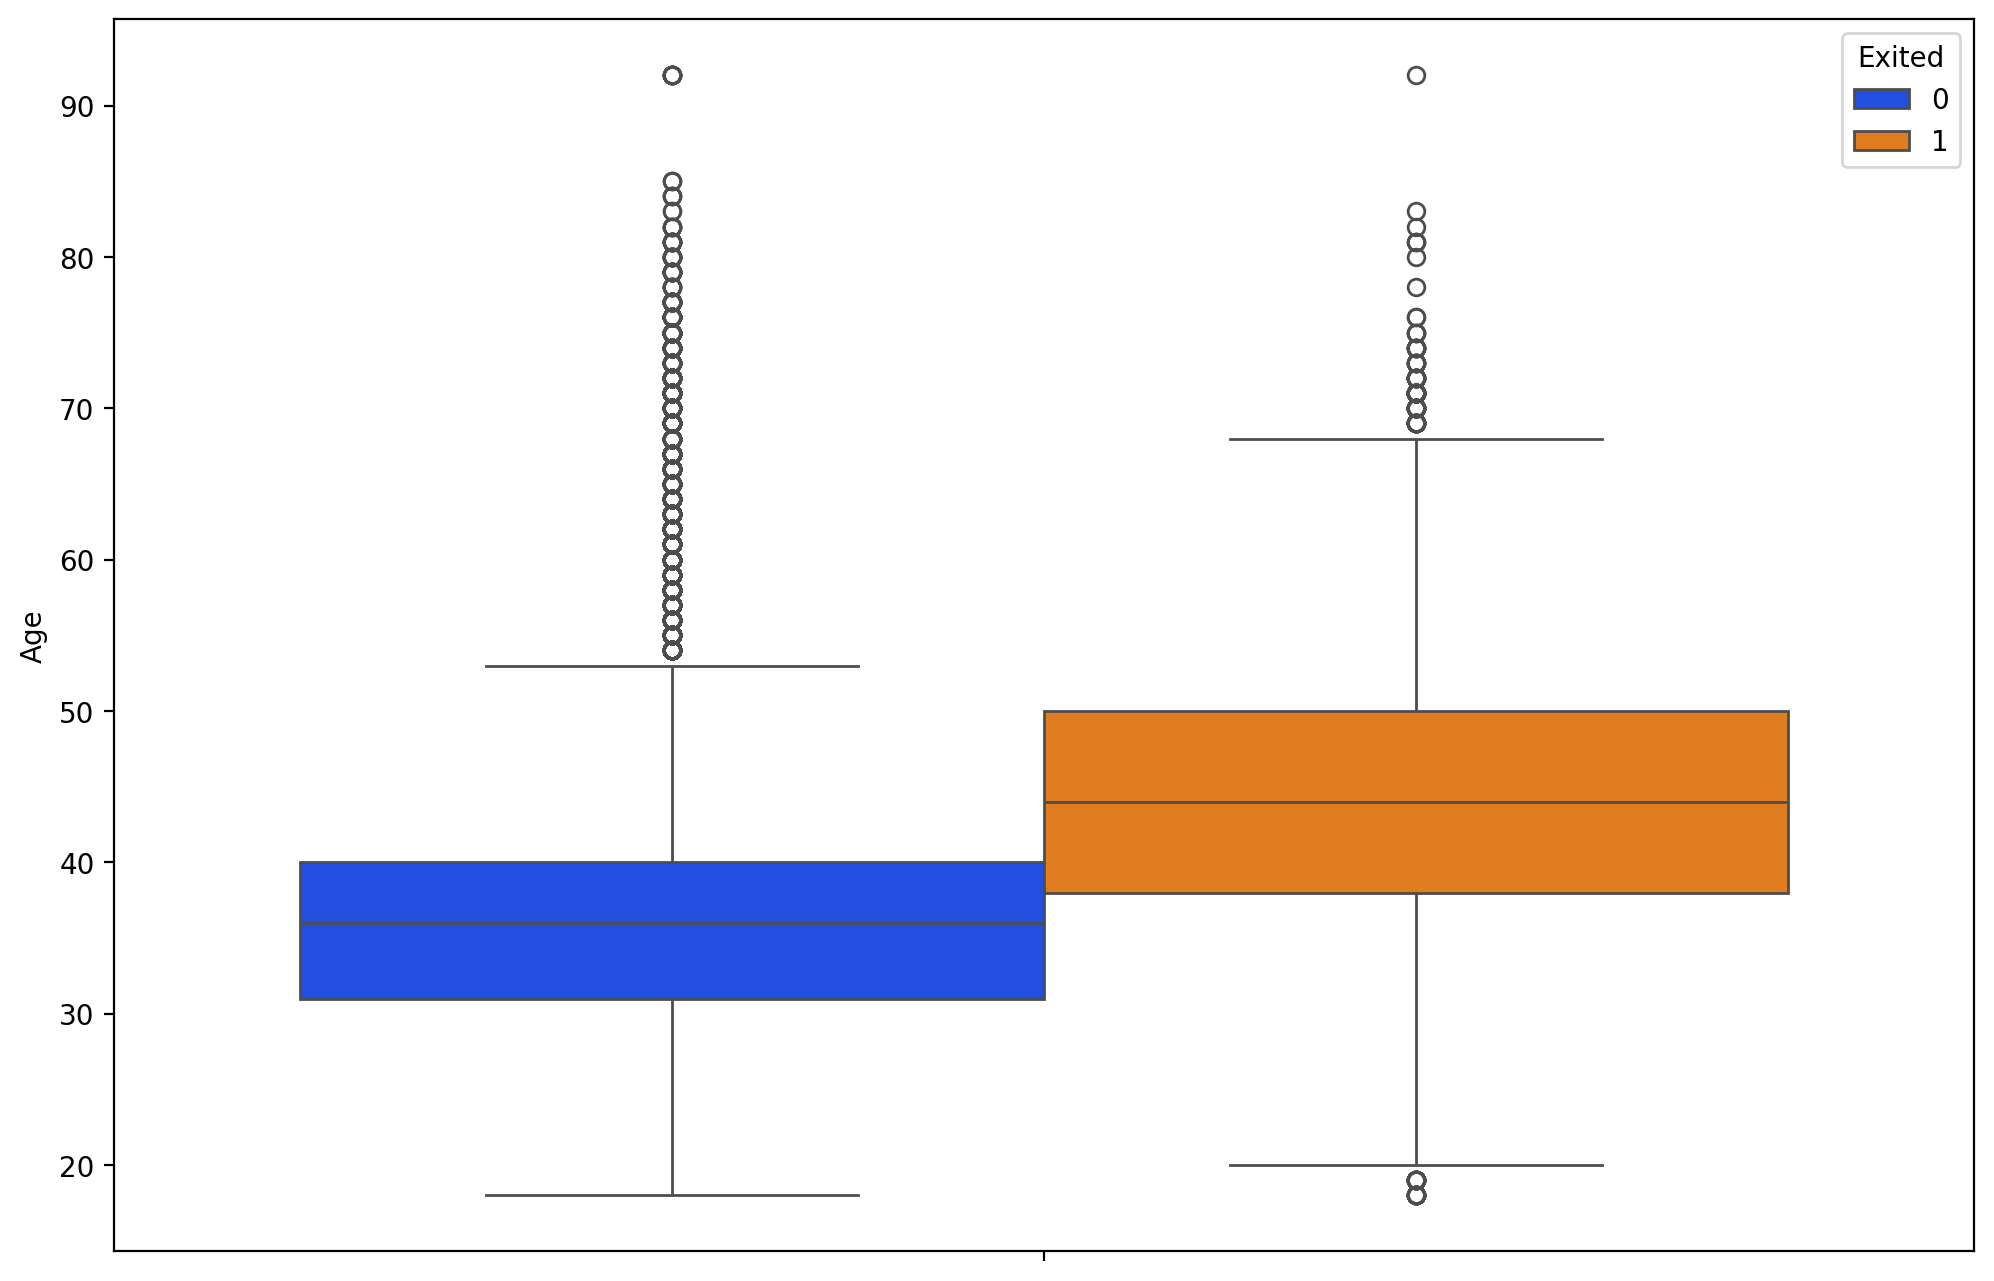

In [130]:
plt.figure(figsize=(12, 8), dpi=200)
sns.boxplot(train, y='Age', hue='Exited')

<Axes: xlabel='Balance', ylabel='Density'>

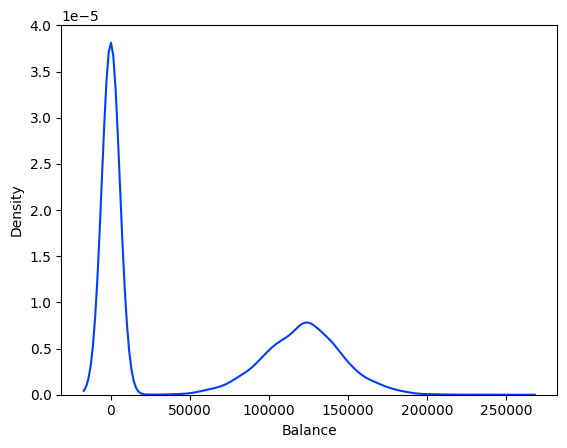

In [131]:
sns.kdeplot(train, x='Balance')

<Axes: ylabel='Balance'>

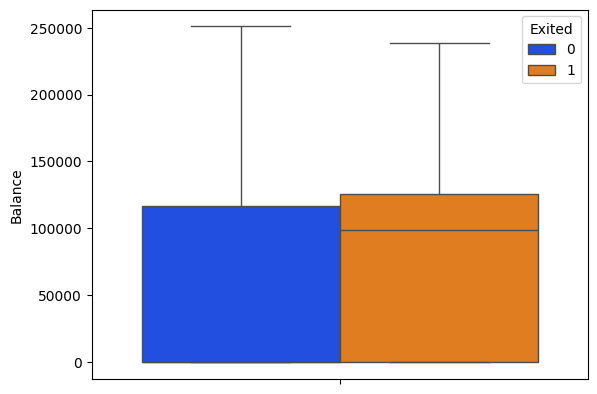

In [132]:
sns.boxplot(train, y='Balance', hue='Exited')

<Axes: xlabel='NumOfProducts', ylabel='Balance'>

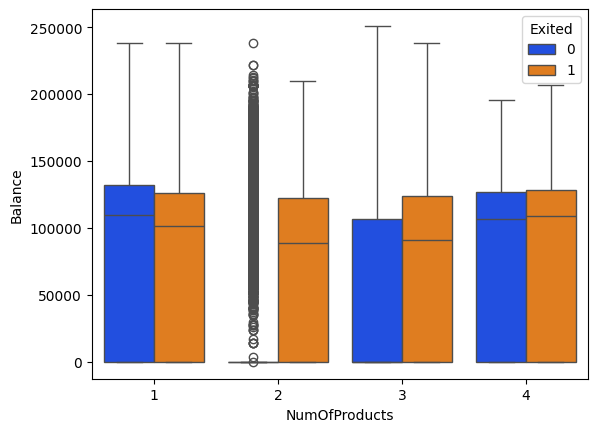

In [133]:
sns.boxplot(train, x='NumOfProducts', y='Balance', hue='Exited')

<Axes: xlabel='CreditScore', ylabel='Density'>

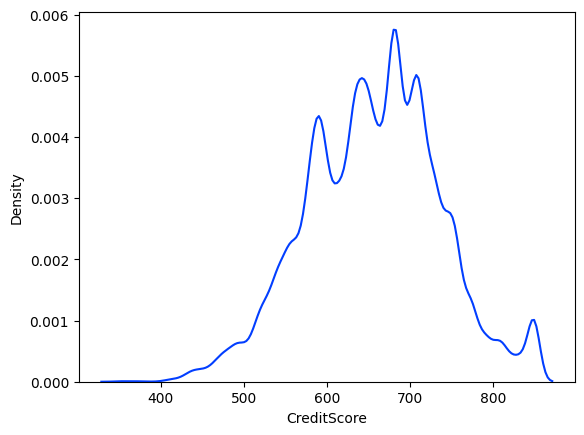

In [134]:
sns.kdeplot(train['CreditScore'])

array([[<Axes: title={'center': 'CustomerId'}>,
        <Axes: title={'center': 'CreditScore'}>,
        <Axes: title={'center': 'Age'}>],
       [<Axes: title={'center': 'Tenure'}>,
        <Axes: title={'center': 'Balance'}>,
        <Axes: title={'center': 'NumOfProducts'}>],
       [<Axes: title={'center': 'HasCrCard'}>,
        <Axes: title={'center': 'IsActiveMember'}>,
        <Axes: title={'center': 'EstimatedSalary'}>],
       [<Axes: title={'center': 'Exited'}>, <Axes: >, <Axes: >]],
      dtype=object)

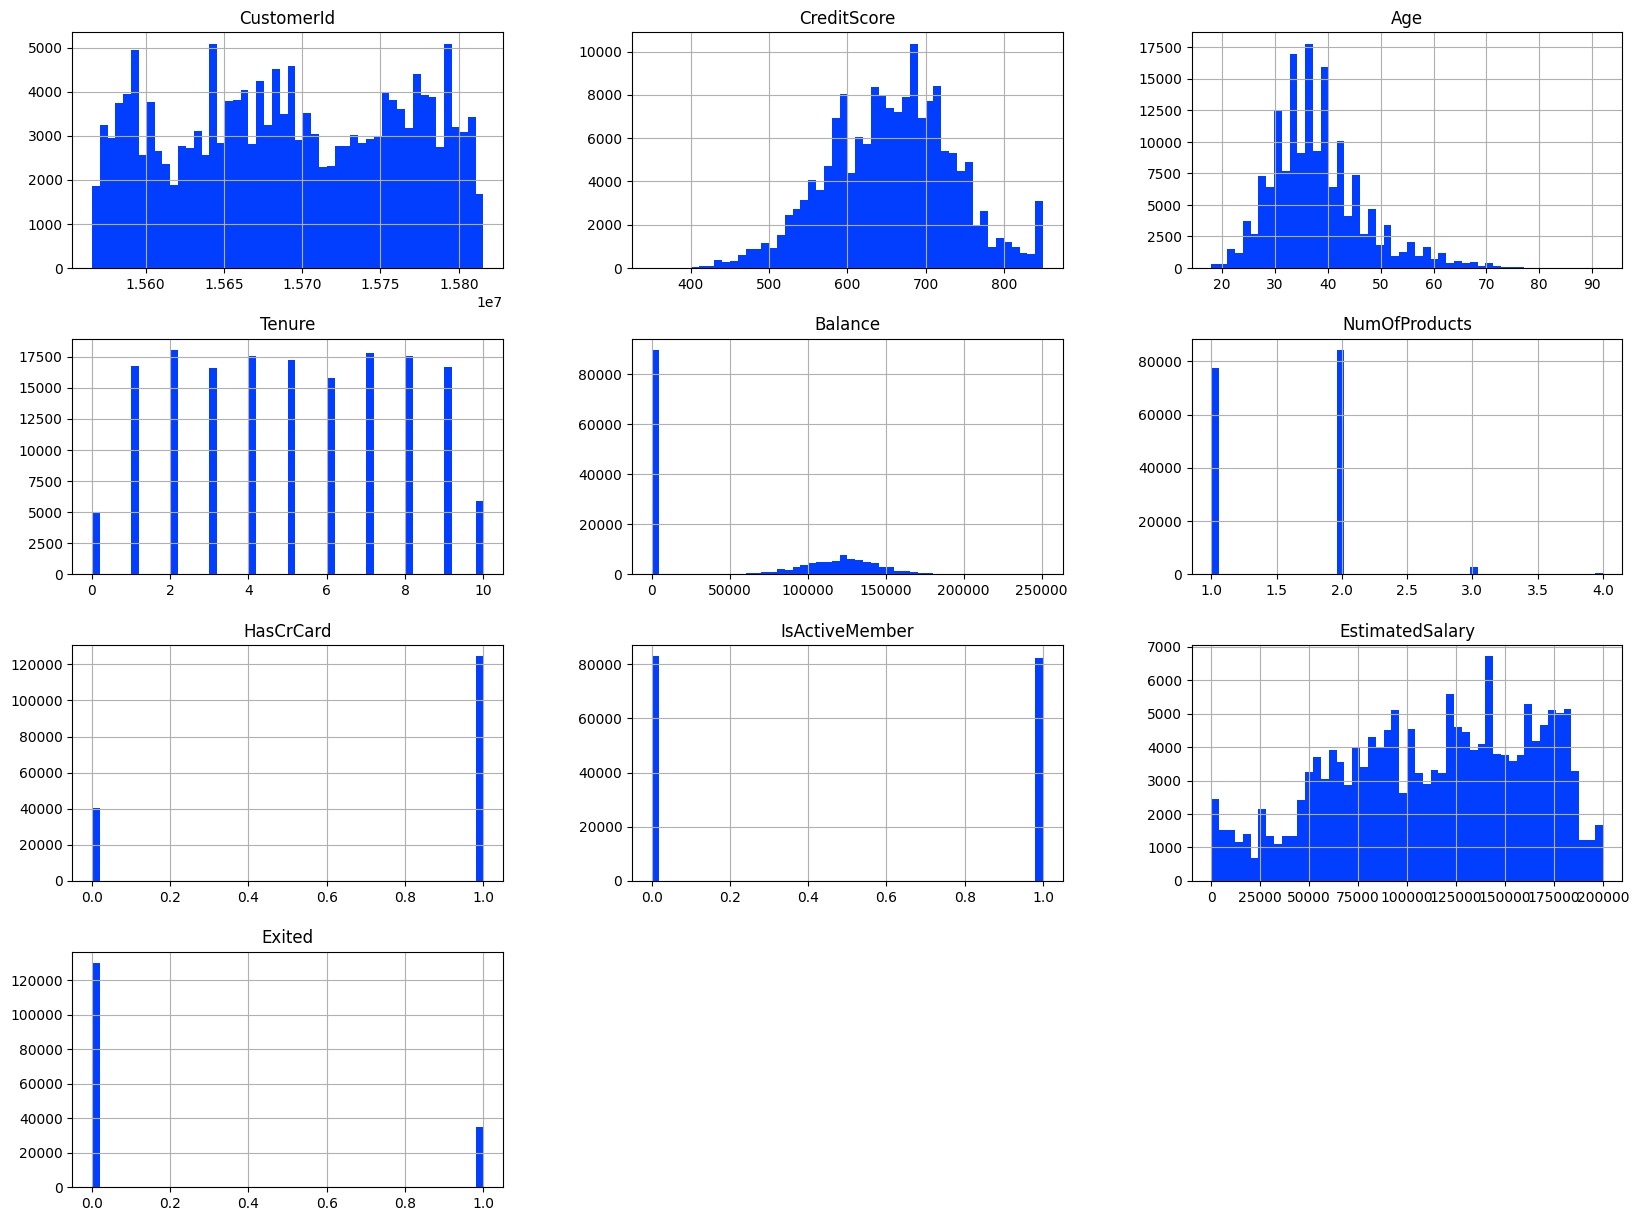

In [135]:
train.hist(bins=50, figsize=(20, 15))

In [136]:
train.isna().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

<Axes: xlabel='Exited', ylabel='count'>

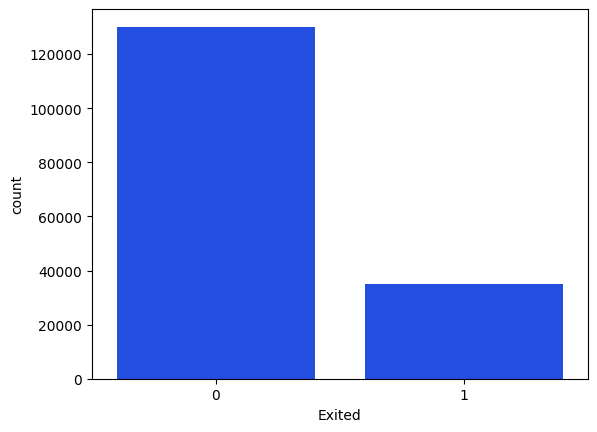

In [137]:
sns.countplot(data=train, x='Exited')

In [138]:
def oversampling(train_data):
    X = train_data.drop(columns='Exited')
    y = train_data['Exited']
    
    ros = RandomOverSampler()
    X_resampled, y_resampled = ros.fit_resample(X, y)
    
    resampled_data = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), 
                                pd.Series(y_resampled, name='Exited')], axis=1)
    return resampled_data

In [139]:
#resampled_data = oversampling(train)

In [140]:
# resampled_data.shape

In [141]:
train.shape

(165034, 13)

In [142]:
train.isna().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

## Data Cleaning

In [143]:
# def drop_emissions(df):
#     index = df[df['Age'] > 90].index
#     df.drop(index=index, inplace=True)
#     df.reset_index(inplace=True, drop=True)

In [144]:
# drop_emissions(train)

In [145]:
target = train['Exited']

In [146]:
train.index

Index([     0,      1,      2,      3,      4,      5,      6,      7,      8,
            9,
       ...
       165024, 165025, 165026, 165027, 165028, 165029, 165030, 165031, 165032,
       165033],
      dtype='int64', name='id', length=165034)

In [147]:
test

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
id,,,,,,,,,,,,
165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00
...,...,...,...,...,...,...,...,...,...,...,...,...
275052,15662091,P'eng,570,Spain,Male,29.0,7,116099.82,1,1.0,1.0,148087.62
275053,15774133,Cox,575,France,Female,36.0,4,178032.53,1,1.0,1.0,42181.68
275054,15728456,Ch'iu,712,France,Male,31.0,2,0.00,2,1.0,0.0,16287.38


In [148]:
df = pd.concat([resampled_data.iloc[:, :-1], test], axis=0).reset_index(drop=True)

In [149]:
df.drop(inplace=True, columns=['CustomerId', 'Surname'])

In [150]:
df.shape

(370249, 10)

## Feature Engineering

In [151]:
df_num = df.select_dtypes(include=['float64', 'int64'])
df_obj = df.select_dtypes(include=object)

In [152]:
ohe = OneHotEncoder()
df_obj = pd.DataFrame(ohe.fit_transform(df_obj).toarray())
df_obj.columns = df_obj.columns.astype(str)

In [153]:
df = pd.concat([df_num, df_obj], axis=1)

In [154]:
df

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,0,1,2,3,4
0,668,33.0,3,0.00,2,1.0,0.0,181449.97,1.0,0.0,0.0,0.0,1.0
1,627,33.0,1,0.00,2,1.0,1.0,49503.50,1.0,0.0,0.0,0.0,1.0
2,678,40.0,10,0.00,2,1.0,0.0,184866.69,1.0,0.0,0.0,0.0,1.0
3,581,34.0,2,148882.54,1,1.0,1.0,84560.88,1.0,0.0,0.0,0.0,1.0
4,716,33.0,5,0.00,2,1.0,1.0,15068.83,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
370244,570,29.0,7,116099.82,1,1.0,1.0,148087.62,0.0,0.0,1.0,0.0,1.0
370245,575,36.0,4,178032.53,1,1.0,1.0,42181.68,1.0,0.0,0.0,1.0,0.0
370246,712,31.0,2,0.00,2,1.0,0.0,16287.38,1.0,0.0,0.0,0.0,1.0
370247,709,32.0,3,0.00,1,1.0,1.0,158816.58,1.0,0.0,0.0,1.0,0.0


In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370249 entries, 0 to 370248
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CreditScore      370249 non-null  int64  
 1   Age              370249 non-null  float64
 2   Tenure           370249 non-null  int64  
 3   Balance          370249 non-null  float64
 4   NumOfProducts    370249 non-null  int64  
 5   HasCrCard        370249 non-null  float64
 6   IsActiveMember   370249 non-null  float64
 7   EstimatedSalary  370249 non-null  float64
 8   0                370249 non-null  float64
 9   1                370249 non-null  float64
 10  2                370249 non-null  float64
 11  3                370249 non-null  float64
 12  4                370249 non-null  float64
dtypes: float64(10), int64(3)
memory usage: 36.7 MB


In [156]:
def log(df):
    df['Age'] = np.log1p(df['Age'])

In [157]:
# # Encoding Gender
# def encoding(df, col):
#     le = LabelEncoder()
#     df[col] = le.fit_transform(df[col]) 


In [158]:
log(df)

In [159]:
# encoding(df, 'Gender')
# encoding(df, 'Geography')

In [160]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,0,1,2,3,4
0,668,3.526361,3,0.00,2,1.0,0.0,181449.97,1.0,0.0,0.0,0.0,1.0
1,627,3.526361,1,0.00,2,1.0,1.0,49503.50,1.0,0.0,0.0,0.0,1.0
2,678,3.713572,10,0.00,2,1.0,0.0,184866.69,1.0,0.0,0.0,0.0,1.0
3,581,3.555348,2,148882.54,1,1.0,1.0,84560.88,1.0,0.0,0.0,0.0,1.0
4,716,3.526361,5,0.00,2,1.0,1.0,15068.83,0.0,0.0,1.0,0.0,1.0


In [161]:
resampled_data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [162]:
resampled_data.isna().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

<Axes: xlabel='Exited', ylabel='count'>

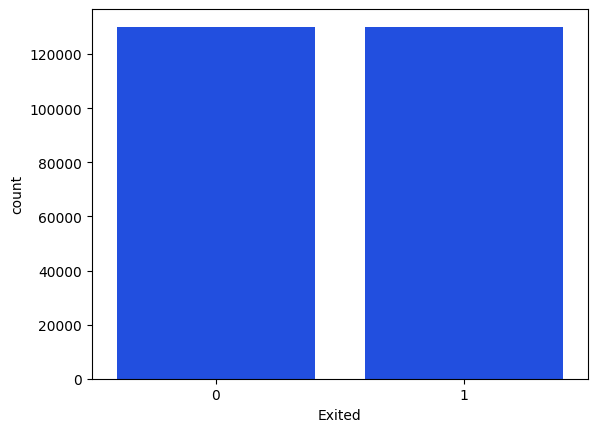

In [163]:
sns.countplot(resampled_data, x='Exited')

In [164]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,0,1,2,3,4
0,668,3.526361,3,0.00,2,1.0,0.0,181449.97,1.0,0.0,0.0,0.0,1.0
1,627,3.526361,1,0.00,2,1.0,1.0,49503.50,1.0,0.0,0.0,0.0,1.0
2,678,3.713572,10,0.00,2,1.0,0.0,184866.69,1.0,0.0,0.0,0.0,1.0
3,581,3.555348,2,148882.54,1,1.0,1.0,84560.88,1.0,0.0,0.0,0.0,1.0
4,716,3.526361,5,0.00,2,1.0,1.0,15068.83,0.0,0.0,1.0,0.0,1.0


In [165]:
# replace_type(df)
log(df)

In [166]:
df.isna().sum()

CreditScore        0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
0                  0
1                  0
2                  0
3                  0
4                  0
dtype: int64

## Data Preprocessing

In [167]:
train = df.iloc[:resampled_data.shape[0], :]
test = df.iloc[resampled_data.shape[0]:, :]

In [168]:
train.shape

(260226, 13)

In [169]:
test.index = test_index

In [170]:
target = resampled_data['Exited']

In [171]:
target

0         0
1         0
2         0
3         0
4         0
         ..
260221    1
260222    1
260223    1
260224    1
260225    1
Name: Exited, Length: 260226, dtype: int64

In [172]:
train = pd.concat([train, target], axis=1)

In [173]:
# # encoding
# le = LabelEncoder()
# train['Gender'] = le.fit_transform(train['Gender'])
# test['Gender'] = le.transform(test['Gender'])

In [174]:
train

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,0,1,2,3,4,Exited
0,668,1.509918,3,0.00,2,1.0,0.0,181449.97,1.0,0.0,0.0,0.0,1.0,0
1,627,1.509918,1,0.00,2,1.0,1.0,49503.50,1.0,0.0,0.0,0.0,1.0,0
2,678,1.550446,10,0.00,2,1.0,0.0,184866.69,1.0,0.0,0.0,0.0,1.0,0
3,581,1.516302,2,148882.54,1,1.0,1.0,84560.88,1.0,0.0,0.0,0.0,1.0,0
4,716,1.509918,5,0.00,2,1.0,1.0,15068.83,0.0,0.0,1.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260221,790,1.595709,8,121438.58,1,1.0,1.0,176471.78,0.0,1.0,0.0,0.0,1.0,1
260222,648,1.643721,8,106288.54,1,1.0,0.0,36639.25,0.0,1.0,0.0,0.0,1.0,1
260223,721,1.628131,6,0.00,1,1.0,0.0,79450.61,0.0,0.0,1.0,0.0,1.0,1
260224,714,1.618011,9,115315.04,1,1.0,0.0,159835.53,0.0,1.0,0.0,1.0,0.0,1


In [175]:
X = train.drop(columns=['Exited'])
y = train['Exited']

In [176]:
train

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,0,1,2,3,4,Exited
0,668,1.509918,3,0.00,2,1.0,0.0,181449.97,1.0,0.0,0.0,0.0,1.0,0
1,627,1.509918,1,0.00,2,1.0,1.0,49503.50,1.0,0.0,0.0,0.0,1.0,0
2,678,1.550446,10,0.00,2,1.0,0.0,184866.69,1.0,0.0,0.0,0.0,1.0,0
3,581,1.516302,2,148882.54,1,1.0,1.0,84560.88,1.0,0.0,0.0,0.0,1.0,0
4,716,1.509918,5,0.00,2,1.0,1.0,15068.83,0.0,0.0,1.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260221,790,1.595709,8,121438.58,1,1.0,1.0,176471.78,0.0,1.0,0.0,0.0,1.0,1
260222,648,1.643721,8,106288.54,1,1.0,0.0,36639.25,0.0,1.0,0.0,0.0,1.0,1
260223,721,1.628131,6,0.00,1,1.0,0.0,79450.61,0.0,0.0,1.0,0.0,1.0,1
260224,714,1.618011,9,115315.04,1,1.0,0.0,159835.53,0.0,1.0,0.0,1.0,0.0,1


In [177]:
y

0         0
1         0
2         0
3         0
4         0
         ..
260221    1
260222    1
260223    1
260224    1
260225    1
Name: Exited, Length: 260226, dtype: int64

In [178]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [179]:
train

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,0,1,2,3,4,Exited
0,668,1.509918,3,0.00,2,1.0,0.0,181449.97,1.0,0.0,0.0,0.0,1.0,0
1,627,1.509918,1,0.00,2,1.0,1.0,49503.50,1.0,0.0,0.0,0.0,1.0,0
2,678,1.550446,10,0.00,2,1.0,0.0,184866.69,1.0,0.0,0.0,0.0,1.0,0
3,581,1.516302,2,148882.54,1,1.0,1.0,84560.88,1.0,0.0,0.0,0.0,1.0,0
4,716,1.509918,5,0.00,2,1.0,1.0,15068.83,0.0,0.0,1.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260221,790,1.595709,8,121438.58,1,1.0,1.0,176471.78,0.0,1.0,0.0,0.0,1.0,1
260222,648,1.643721,8,106288.54,1,1.0,0.0,36639.25,0.0,1.0,0.0,0.0,1.0,1
260223,721,1.628131,6,0.00,1,1.0,0.0,79450.61,0.0,0.0,1.0,0.0,1.0,1
260224,714,1.618011,9,115315.04,1,1.0,0.0,159835.53,0.0,1.0,0.0,1.0,0.0,1


In [180]:
X_train

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,0,1,2,3,4
77265,703,1.439569,3,142381.08,1,0.0,1.0,176519.71,1.0,0.0,0.0,0.0,1.0
249762,574,1.555545,0,0.00,2,1.0,0.0,70550.00,1.0,0.0,0.0,0.0,1.0
100703,598,1.560500,8,0.00,2,1.0,1.0,155711.82,1.0,0.0,0.0,0.0,1.0
132695,733,1.539779,5,0.00,2,1.0,1.0,70778.63,1.0,0.0,0.0,1.0,0.0
15855,628,1.496434,9,155978.17,1,0.0,1.0,72350.17,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,665,1.539779,1,96645.54,2,0.0,0.0,171413.66,1.0,0.0,0.0,0.0,1.0
103694,751,1.565317,7,0.00,2,1.0,0.0,88866.39,1.0,0.0,0.0,0.0,1.0
131932,753,1.545194,7,0.00,2,1.0,0.0,167973.63,1.0,0.0,0.0,1.0,0.0
146867,685,1.587564,4,0.00,2,1.0,1.0,24998.75,1.0,0.0,0.0,1.0,0.0


In [181]:
scaler = StandardScaler()

In [182]:
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

## Model Building

## Logistic Regression

In [72]:
logistic_regression = make_pipeline(StandardScaler(), LogisticRegression())

In [121]:
logistic_regression.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [93]:
pred = logistic_regression.predict(X_test)

In [94]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.95      0.85      0.90     43881
           1       0.36      0.67      0.47      5626

    accuracy                           0.83     49507
   macro avg       0.66      0.76      0.68     49507
weighted avg       0.89      0.83      0.85     49507



In [95]:
train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,0,1,3.526361,3,0.00,2,1.0,0.0,181449.97,0
1,627,0,1,3.526361,1,0.00,2,1.0,1.0,49503.50,0
2,678,0,1,3.713572,10,0.00,2,1.0,0.0,184866.69,0
3,581,0,1,3.555348,2,148882.54,1,1.0,1.0,84560.88,0
4,716,2,1,3.526361,5,0.00,2,1.0,1.0,15068.83,0


In [96]:
logistic_regression.named_steps['logisticregression'].coef_

array([[-0.06072818,  0.09737438, -0.33559034,  0.93731722, -0.04284979,
         0.14961656, -0.44845009, -0.05954504, -0.6312192 ,  0.05627813]])

## XGBClassifier

In [148]:
def stock_xgboost():
    xgbc = XGBClassifier()
    xgbc.fit(X_train, y_train)
    pred = xgbc.predict(X_test)
    return xgbc, pred

In [128]:
xgbc, pred = stock_xgboost()

In [129]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.82      0.83      0.82     38889
           1       0.83      0.83      0.83     39179

    accuracy                           0.83     78068
   macro avg       0.83      0.83      0.83     78068
weighted avg       0.83      0.83      0.83     78068



In [147]:
##Tuning XGBC model

In [156]:
param_grid = {
    'max_depth': [4, 6, 10, 12, 15],
    'min_child_weight': [1, 4, 8],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0, 0.3, 0.6, 0.8],
    'colsample_bytree': [0, 0.3, 0.6, 0.8],
    'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05]
}

In [157]:
pipe_xgb = make_pipeline(StandardScaler(), RandomizedSearchCV(XGBClassifier(verbosity=3), 
                                                              param_distributions=param_grid,
                                                              n_iter=10,
                                                              cv=3,
                                                              verbose=3,
                                                              scoring='roc_auc'
                                                             ))

In [163]:
pipe_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[13:31:33] ======== Monitor (0): HostSketchContainer ========
[13:31:33] AllReduce: 0.001319s, 1 calls @ 1319us

[13:31:33] MakeCuts: 0.001355s, 1 calls @ 1355us

[13:31:33] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[13:31:34] ======== Monitor (0): Learner ========
[13:31:34] Configure: 0.000384s, 1 calls @ 384us

[13:31:34] EvalOneIter: 0.001133s, 100 calls @ 1133us

[13:31:34] GetGradient: 0.138662s, 100 calls @ 138662us

[13:31:34] PredictRaw: 0.00016s, 100 calls @ 160us

[13:31:34] UpdateOneIter: 0.905513s, 100 calls @ 905513us

[13:31:34] ======== Monitor (0): GBTree ========
[13:31:34] BoostNewTrees: 0.762663s, 100 calls @ 762663us

[13:31:34] CommitModel: 8.6e-05s, 100 calls @ 86us

[13:31:34] ======== Monitor (0): HistUpdater ========
[13:31:34] BuildHistogram: 0.30196s, 857 calls @ 301960us

[13

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomizedsearchcv',
                 RandomizedSearchCV(cv=3,
                                    estimator=XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=None,
                                                            feature_types=None,
                                                            gamma=None,
                                                            grow_p...
                                                            monotone_constraints=None,
                                                            multi_strategy=None,
                                                            n_estimators=None,
                                                            n_jobs=None,
                                                            num_parallel_tree=None,
                                                            random_state=None, ...),
                                    param_distributions={'colsample_bytree': [0,
                                                                              0.3,
                                                                              0.6,
                                                                              0.8],
                                                         'gamma': [0.5, 1, 1.5,
                                                                   2, 5],
                                                         'max_depth': [4, 6, 10,
                                                                       12, 15],
                                                         'min_child_weight': [1,
                                                                              4,
                                                                              8],
                                                         'reg_alpha': [0, 0.001,
                                                                       0.005,
                                                                       0.01,
                                                                       0.05],
                                                         'subsample': [0, 0.3,
                                                                       0.6,
                                                                       0.8]},
                                    scoring='roc_auc', verbose=3))])

In [167]:
# pipe_xgb.named_steps['randomizedsearchcv'].best_params_
# {'subsample': 0.8,
#  'reg_alpha': 0.01,
#  'min_child_weight': 1,
#  'max_depth': 15,
#  'gamma': 1,
#  'colsample_bytree': 0.8}
# score=0.9

In [162]:
# pipe_xgb.named_steps['randomizedsearchcv'].best_params_ names_xgb=one
# {'subsample': 0.6,
#  'reg_alpha': 0.005,
#  'min_child_weight': 1,
#  'max_depth': 10,
#  'gamma': 1,
#  'colsample_bytree': 0.8}
# score 0.87

In [185]:
xgb = make_pipeline(StandardScaler(), XGBClassifier(subsample=0.6, reg_alpha=0.005,
                        min_child_weight=1, max_depth=15, gamma=1, colsample_bytree=0.8, scale_pos_weight=2.5823850371302717))

In [186]:
xgb.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=1, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=15, max_leaves=None,
                               min_child_weight=1, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [187]:
pred = xgb.predict(X_test)

In [188]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.84      0.97      0.90     33482
           1       0.98      0.86      0.91     44586

    accuracy                           0.91     78068
   macro avg       0.91      0.91      0.91     78068
weighted avg       0.92      0.91      0.91     78068



In [165]:
xgb_predict = pipe_xgb.predict(X_test)

[13:32:10] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0


In [166]:
print(classification_report(xgb_predict, y_test))

              precision    recall  f1-score   support

           0       0.87      0.92      0.90     36519
           1       0.93      0.88      0.90     41549

    accuracy                           0.90     78068
   macro avg       0.90      0.90      0.90     78068
weighted avg       0.90      0.90      0.90     78068



In [207]:
xgb_params = {'learning_rate'       : 0.07891973803508055,
    'max_depth'           : 5,
    'min_child_weight'    : 9,
    'gamma'               : 0.18409847303728766,
    'subsample'           : 0.8528790072898303,
    'colsample_bytree'    : 0.7366486650079365,
    'lambda'              : 0.7118208977923494,
    'alpha'               : 0.5252170103074075,
    'scale_pos_weight'    : 2.5823850371302717,
    'n_estimators'       : 500,
    'objective'          : 'binary:logistic',
    'tree_method'        :'auto',
    'eval_metric'        :'auc',
             }

In [208]:
xgb = make_pipeline(StandardScaler(), XGBClassifier(**xgb_params))

In [209]:
xgb.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbclassifier',
                 XGBClassifier(alpha=0.5252170103074075, base_score=None,
                               booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7366486650079365, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='auc',
                               feature_types=None, gamma=0.18409847...66,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               lambda=0.7118208977923494,
                               learning_rate=0.07891973803508055, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=5,
                               max_leaves=None, min_child_weight=9, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=500, n_jobs=None, ...))])

In [210]:
x_pred = xgb.predict(X_test)

In [211]:
print(classification_report(x_pred, y_test))

              precision    recall  f1-score   support

           0       0.66      0.90      0.76     28424
           1       0.93      0.73      0.82     49644

    accuracy                           0.79     78068
   macro avg       0.79      0.81      0.79     78068
weighted avg       0.83      0.79      0.80     78068



## XGB with optuna optimization

In [225]:
def objective(trial):
    #XGB params to tune
    params = {
        'n_estimators'     : 250,
        'objective'        : 'binary:logistic',
        'tree_method'      :'auto',
        'eval_metric'      :'auc',
        'random_state'     : RANDOM,
        'learning_rate'    : trial.suggest_float('learning_rate', 0.03, 0.1),  
        'max_depth'        : trial.suggest_int('max_depth',3, 12),
        'min_child_weight' : trial.suggest_int('min_child_weight',3,12),
        'gamma'            : trial.suggest_float('gamma', 0, 0.5), 
        'subsample'        : trial.suggest_float('subsample', 0.5, 0.9), 
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.5, 0.9), 
        'lambda'           : trial.suggest_float('lambda', 0.5, 0.9),
        'alpha'            : trial.suggest_float('alpha', 0.5, 0.9),
        'scale_pos_weight' : trial.suggest_float('scale_pos_weight', 2, 8),
    }
    # model
    xgb = XGBClassifier(**params)

    # use stratified kfold to evalute each set of model weights
    skf= StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM)

    # Calculate the auc for each set of model weights
    auc = abs(cross_val_score(xgb, X_train, y_train, cv=skf, scoring='roc_auc').mean())
    
    return auc

In [226]:
# create the study and run the optimization
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM))
study.optimize(objective, n_trials=50)

# get the best weights from the optimization
xgb_best = study.best_params
print(study.best_value)
print(xgb_best)

[I 2024-01-30 20:12:24,126] A new study created in memory with name: no-name-eca4fa06-1058-438b-8d08-4e98b3dc96e9
[I 2024-01-30 20:12:27,310] Trial 0 finished with value: 0.8874784958814604 and parameters: {'learning_rate': 0.0303732612454978, 'max_depth': 3, 'min_child_weight': 8, 'gamma': 0.05009417960653628, 'subsample': 0.741432947760096, 'colsample_bytree': 0.7106659610487188, 'lambda': 0.8746677603135031, 'alpha': 0.8075374136686688, 'scale_pos_weight': 7.031471673894902}. Best is trial 0 with value: 0.8874784958814604.
[I 2024-01-30 20:12:35,154] Trial 1 finished with value: 0.9300993241125614 and parameters: {'learning_rate': 0.0694244092150325, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 0.21536388936813183, 'subsample': 0.606208022771669, 'colsample_bytree': 0.6613542303452944, 'lambda': 0.8019970534569715, 'alpha': 0.7437973766008829, 'scale_pos_weight': 7.305512118802548}. Best is trial 1 with value: 0.9300993241125614.
[I 2024-01-30 20:12:39,080] Trial 2 finished wit

0.9434086059072211
{'learning_rate': 0.08375585546676781, 'max_depth': 12, 'min_child_weight': 4, 'gamma': 0.4483875911126779, 'subsample': 0.6619371599439788, 'colsample_bytree': 0.7765355459914761, 'lambda': 0.5352830697209219, 'alpha': 0.5314975761420684, 'scale_pos_weight': 3.507012769182676}


In [227]:
xgb_best

{'learning_rate': 0.08375585546676781,
 'max_depth': 12,
 'min_child_weight': 4,
 'gamma': 0.4483875911126779,
 'subsample': 0.6619371599439788,
 'colsample_bytree': 0.7765355459914761,
 'lambda': 0.5352830697209219,
 'alpha': 0.5314975761420684,
 'scale_pos_weight': 3.507012769182676}

In [228]:
xgb = XGBClassifier(**xgb_best)

In [229]:
xgb.fit(X_train, y_train)

XGBClassifier(alpha=0.5314975761420684, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7765355459914761, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.4483875911126779,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.5352830697209219,
              learning_rate=0.08375585546676781, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, ...)

In [230]:
pred = xgb.predict(X_test)

In [231]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.96      0.71      0.81     38939
           1       0.77      0.97      0.86     39129

    accuracy                           0.84     78068
   macro avg       0.86      0.84      0.83     78068
weighted avg       0.86      0.84      0.83     78068



## LGBMClassifier

In [212]:
lgbm_params = {'learning_rate'       : 0.07195170675490274,
    'max_depth'           : 10,
    'min_child_samples'   : 29,
    'num_leaves'          : 32,
    'subsample'           : 0.6195074612443567,
    'colsample_bytree'    : 0.6256023270088532,
    'reg_lambda'          : 1.2749689670536513,
    'reg_alpha'           : 2.9837880825088554,
    'scale_pos_weight'    : 2.322854548999615,
    'n_jobs'              : -1,
    'importance_type'     : 'gain',
    'objective'           : 'binary',
    'n_estimators'        : 500,
    'metric'              : "auc",
    'boosting_type'       : 'gbdt'}

In [213]:
# lgbm_params = {'n_estimators':1400,'max_depth': 50, 'learning_rate': 0.02,'min_child_weight': 2.83, 'min_child_samples': 240,'subsample': 0.98, 'subsample_freq': 2,'colsample_bytree': 0.65, 'num_leaves': 44,
#               'scale_pos_weight':2.322854548999615}
lgbm_clf = make_pipeline(StandardScaler(), LGBMClassifier(**lgbm_params,random_state=42, verbose=-1))

In [214]:
lgbm_clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lgbmclassifier',
                 LGBMClassifier(colsample_bytree=0.6256023270088532,
                                importance_type='gain',
                                learning_rate=0.07195170675490274, max_depth=10,
                                metric='auc', min_child_samples=29,
                                n_estimators=500, n_jobs=-1, num_leaves=32,
                                objective='binary', random_state=42,
                                reg_alpha=2.9837880825088554,
                                reg_lambda=1.2749689670536513,
                                scale_pos_weight=2.322854548999615,
                                subsample=0.6195074612443567, verbose=-1))])

In [215]:
pred = lgbm_clf.predict(X_test)

In [216]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.67      0.90      0.77     29323
           1       0.92      0.74      0.82     48745

    accuracy                           0.80     78068
   macro avg       0.80      0.82      0.80     78068
weighted avg       0.83      0.80      0.80     78068



In [143]:
roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1])

0.31232595415024766

In [455]:
# score = cross_val_score(lgbm_clf, X_train,y_train, n_jobs=-1,error_score='raise', cv=10,scoring = 'roc_auc').mean()
# print(score)
# 0.9036382789181043


In [194]:
## Tuning LGBM model

In [210]:
param_lgbm = {
    'num_leaves': [20, 31, 40, 50],
    'learning_rate': [0.1, 0.2, 0.5],
    'n_estimators': [100, 400, 800, 1000, 1500],
    'subsample': [0.2, 0.5, 0.8, 1],
    'subsample_freq': [0, 1, 2, 4],
    'colsample_bytree': [0.2, 0.5, 0.8, 1],
    'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05]
}

In [211]:
pipe_lgbm = make_pipeline(StandardScaler(), RandomizedSearchCV(LGBMClassifier(), 
                                                               param_distributions=param_lgbm,
                                                               cv=3,
                                                               n_iter=10,
                                                               verbose=2,
                                                               scoring='roc_auc'))

In [212]:
pipe_lgbm.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Number of positive: 60656, number of negative: 60782
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 870
[LightGBM] [Info] Number of data points in the train set: 121438, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499481 -> initscore=-0.002075
[LightGBM] [Info] Start training from score -0.002075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.5, learning_rate=0.5, n_estimators=1500, num_leaves=4

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomizedsearchcv',
                 RandomizedSearchCV(cv=3, estimator=LGBMClassifier(),
                                    param_distributions={'colsample_bytree': [0.2,
                                                                              0.5,
                                                                              0.8,
                                                                              1],
                                                         'learning_rate': [0.1,
                                                                           0.2,
                                                                           0.5],
                                                         'n_estimators': [100,
                                                                          400,
                                                                          800,
                                                                          1000,
                                                                          1500],
                                                         'num_leaves': [20, 31,
                                                                        40,
                                                                        50],
                                                         'reg_alpha': [0, 0.001,
                                                                       0.005,
                                                                       0.01,
                                                                       0.05],
                                                         'subsample': [0.2, 0.5,
                                                                       0.8, 1],
                                                         'subsample_freq': [0,
                                                                            1,
                                                                            2,
                                                                            4]},
                                    scoring='roc_auc', verbose=2))])

In [216]:
pipe_lgbm.named_steps['randomizedsearchcv'].best_params_
# {'subsample_freq': 1,
#  'subsample': 0.8,
#  'reg_alpha': 0.005,
#  'num_leaves': 31,
#  'n_estimators': 1000,
#  'learning_rate': 0.1,
#  'colsample_bytree': 0.5}
#score = 0.84
# {'subsample_freq': 0,
#  'subsample': 1,
#  'reg_alpha': 0.005,
#  'num_leaves': 40,
#  'n_estimators': 1500,
#  'learning_rate': 0.5,
#  'colsample_bytree': 0.5}
# score = 0.89

{'subsample_freq': 0,
 'subsample': 1,
 'reg_alpha': 0.005,
 'num_leaves': 40,
 'n_estimators': 1500,
 'learning_rate': 0.5,
 'colsample_bytree': 0.5}

In [214]:
lgbm_pred = pipe_lgbm.predict(X_test)

In [215]:
print(classification_report(lgbm_pred, y_test))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89     36008
           1       0.93      0.87      0.90     42060

    accuracy                           0.89     78068
   macro avg       0.89      0.90      0.89     78068
weighted avg       0.90      0.89      0.89     78068



In [75]:
lgbm = make_pipeline(StandardScaler(), LGBMClassifier(subsample_freq=0,
                                                      subsample=1,
                                                      num_leaves=200,
                                                      n_estimators=1000,
                                                      learning_rate=0.04,
                                                      colsample_bytree=0.5))

In [76]:
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 90984, number of negative: 91174
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 872
[LightGBM] [Info] Number of data points in the train set: 182158, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499478 -> initscore=-0.002086
[LightGBM] [Info] Start training from score -0.002086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lgbmclassifier',
                 LGBMClassifier(colsample_bytree=0.5, learning_rate=0.04,
                                n_estimators=1000, num_leaves=200,
                                subsample=1))])

In [77]:
pred = lgbm.predict(X_test)

In [78]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87     37754
           1       0.89      0.86      0.87     40314

    accuracy                           0.87     78068
   macro avg       0.87      0.87      0.87     78068
weighted avg       0.87      0.87      0.87     78068



In [153]:
roc_auc_score(y_test, lgbm.predict_proba(X_test)[:, 1])

0.9410975796946118

In [73]:
roc = []
for n in range(100, 1000, 100):
    lgbm = make_pipeline(StandardScaler(), LGBMClassifier(subsample_freq=0,
                                                      subsample=1,
                                                      num_leaves=200,
                                                      n_estimators=n,
                                                      learning_rate=0.04,
                                                      colsample_bytree=0.5))
    lgbm.fit(X_train, y_train)
    roc.append(roc_auc_score(y_test, lgbm.predict_proba(X_test)[:, 1]))


[LightGBM] [Info] Number of positive: 90984, number of negative: 91174
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 872
[LightGBM] [Info] Number of data points in the train set: 182158, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499478 -> initscore=-0.002086
[LightGBM] [Info] Start training from score -0.002086
[LightGBM] [Info] Number of positive: 90984, number of negative: 91174
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 872
[LightGBM] [Info] Number of data points in the train set: 182158, number of used features: 13
[LightGBM] [Info] 

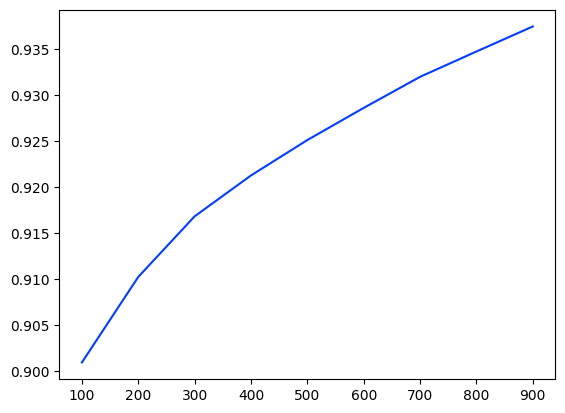

In [74]:
plt.plot(range(100, 1000, 100), roc)

## Gradient Boosting 

In [306]:
param_gbt = {
    'loss': ['log_loss', 'exponential'],
    'learning_rate': [0.001, 0.1, 0.2, 0.5],
    'n_estimators': [100, 500, 1000, 1500],
    'subsample': [0.1, 0.5, 0.8, 1],
    'criterion': ['friedman_mse', 'squared_error'],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 5, 10, 15],
    'min_weight_fraction_leaf': [0, 0.1, 0.3, 0.5],
    'max_depth': [3, 4, 8, 12],
    'max_features': ['sqrt', 'log2', None],
    'max_leaf_nodes': [2, 5, 9, 12, 15]
}

In [85]:
gbt = make_pipeline(StandardScaler(), RandomizedSearchCV(GradientBoostingClassifier(),
                                                         param_distributions=param_gbt,
                                                         verbose=2,
                                                         cv=3,
                                                         n_iter=10,
                                                         scoring='roc_auc'))

NameError: name 'param_gbt' is not defined

In [84]:
gbt.fit(X_train, y_train)

NameError: name 'gbt' is not defined

In [314]:
gbt.named_steps['randomizedsearchcv'].best_params_
# {'subsample': 0.8,
#  'n_estimators': 500,
#  'min_weight_fraction_leaf': 0,
#  'min_samples_split': 5,
#  'min_samples_leaf': 1,
#  'max_leaf_nodes': 15,
#  'max_features': 'log2',
#  'max_depth': 8,
#  'loss': 'log_loss',
#  'learning_rate': 0.2,
#  'criterion': 'friedman_mse'}
# score = 0.82

{'subsample': 0.8,
 'n_estimators': 500,
 'min_weight_fraction_leaf': 0,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_leaf_nodes': 15,
 'max_features': 'log2',
 'max_depth': 8,
 'loss': 'log_loss',
 'learning_rate': 0.2,
 'criterion': 'friedman_mse'}

In [312]:
gbt_pred = gbt.predict(X_test)

In [313]:
print(classification_report(y_test, gbt_pred))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82     38939
           1       0.82      0.82      0.82     39129

    accuracy                           0.82     78068
   macro avg       0.82      0.82      0.82     78068
weighted avg       0.82      0.82      0.82     78068



In [86]:
gbt = make_pipeline(StandardScaler(), GradientBoostingClassifier(subsample=0.8, n_estimators=500, min_weight_fraction_leaf=0,
                                                                min_samples_split=5,
                                                                min_samples_leaf=1,
                                                                max_leaf_nodes=15,
                                                                max_features='log2',
                                                                max_depth=8,
                                                                loss='log_loss',
                                                                learning_rate=0.2,
                                                                criterion='friedman_mse'))

In [87]:
gbt.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(learning_rate=0.2, max_depth=8,
                                            max_features='log2',
                                            max_leaf_nodes=15,
                                            min_samples_split=5,
                                            min_weight_fraction_leaf=0,
                                            n_estimators=500, subsample=0.8))])

In [88]:
gbt_pred = gbt.predict(X_test)

In [89]:
print(classification_report(gbt_pred, y_test))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82     39202
           1       0.82      0.82      0.82     38866

    accuracy                           0.82     78068
   macro avg       0.82      0.82      0.82     78068
weighted avg       0.82      0.82      0.82     78068



In [99]:
roc_auc_score(y_test, gbt.predict_proba(X_test)[:, 1])

0.9040607996802635

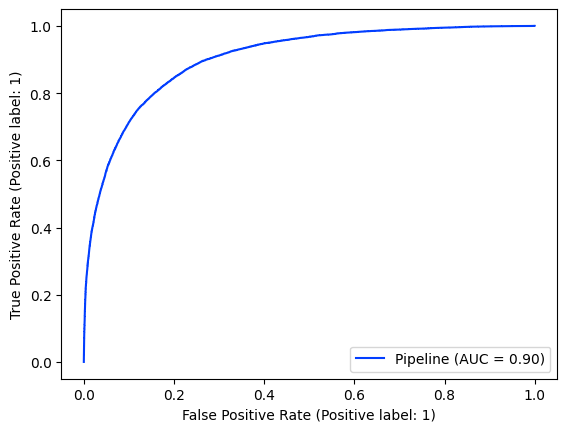

In [100]:
RocCurveDisplay.from_estimator(gbt, X_test, y_test, )

## RandomForest

In [315]:
param_grid = { 
    'n_estimators': [200, 300, 600, 1000],
    'max_depth' : [8, 10, 12],
    'criterion' :['gini', 'entropy', 'log_loss'],
    'max_features': ['sqrt', 'log2', None],
    'max_leaf_nodes': [None, 1, 5, 10, 15],
    'oob_score': [False, True]
}

In [316]:
pipe_forest = make_pipeline(StandardScaler(), RandomizedSearchCV(estimator=RandomForestClassifier(max_features='log2'),
                                                                param_distributions=param_grid,
                                                                cv=3,
                                                                scoring='roc_auc',
                                                                n_iter=10,
                                                                verbose=True))

In [317]:
pipe_forest.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


KeyboardInterrupt: 

In [143]:
pipe_forest.named_steps['randomizedsearchcv'].best_params_
#  {'n_estimators': 200,
#  'max_features': 'log2',
#  'max_depth': 8,
#  'criterion': 'entropy'}

{'n_estimators': 200,
 'max_features': 'log2',
 'max_depth': 10,
 'criterion': 'gini'}

In [144]:
forest_predict = pipe_forest.predict(X_test)

In [145]:
print(classification_report(forest_predict, y_test))

              precision    recall  f1-score   support

           0       0.82      0.81      0.82     39158
           1       0.81      0.82      0.82     38910

    accuracy                           0.82     78068
   macro avg       0.82      0.82      0.82     78068
weighted avg       0.82      0.82      0.82     78068



In [90]:
forest = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=200,
                                                                max_features='log2',
                                                                max_depth=8,
                                                                criterion='entropy'))

In [91]:
forest.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy', max_depth=8,
                                        max_features='log2',
                                        n_estimators=200))])

In [92]:
forest_predict = forest.predict(X_test)

In [93]:
print(classification_report(forest_predict, y_test))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80     38938
           1       0.80      0.80      0.80     39130

    accuracy                           0.80     78068
   macro avg       0.80      0.80      0.80     78068
weighted avg       0.80      0.80      0.80     78068



In [94]:
roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1])

0.8845158410550134

## CatBoostClassifier

In [201]:
cat_params = {
    'learning_rate'          : 0.09986460106129999,
    'depth'                  : 5,
    'min_data_in_leaf'       : 6,
    'l2_leaf_reg'            : 4,
    'bagging_temperature'    : 2,
    'random_strength'        : 0.35546080573163874,
    'colsample_bylevel'      : 0.750063056890726,
    'objective'              : 'Logloss',
    'iterations'             : 250,
    'eval_metric'            : "AUC",
    'class_weights'          :[1,4],
    'verbose'                : 0,
}

In [202]:
pipe_cbc = make_pipeline(StandardScaler(), CatBoostClassifier(**cat_params))

In [203]:
pipe_cbc.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x0000021E0816C2D0>)])

In [204]:
pred = pipe_cbc.predict(X_test)

In [205]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.92      0.53      0.67     38939
           1       0.67      0.95      0.79     39129

    accuracy                           0.74     78068
   macro avg       0.79      0.74      0.73     78068
weighted avg       0.79      0.74      0.73     78068



## VotingCLassifier

In [118]:
voting_clf = VotingClassifier(estimators=[('xgb', xgb), ('rf', forest), ('lgbm', lgbm_clf), ('gbt', gbt),
                                          ('cbc', pipe_cbc)],
                       voting='soft')

In [119]:
voting_clf.fit(X_train, y_train)

Learning rate set to 0.095092
0:	learn: 0.6364773	total: 25.8ms	remaining: 25.8s
1:	learn: 0.5925161	total: 47ms	remaining: 23.5s
2:	learn: 0.5602663	total: 66.5ms	remaining: 22.1s
3:	learn: 0.5337592	total: 93.4ms	remaining: 23.3s
4:	learn: 0.5128761	total: 114ms	remaining: 22.7s
5:	learn: 0.4970680	total: 135ms	remaining: 22.4s
6:	learn: 0.4844584	total: 159ms	remaining: 22.5s
7:	learn: 0.4741967	total: 179ms	remaining: 22.2s
8:	learn: 0.4658735	total: 200ms	remaining: 22.1s
9:	learn: 0.4589413	total: 225ms	remaining: 22.3s
10:	learn: 0.4531729	total: 245ms	remaining: 22.1s
11:	learn: 0.4480253	total: 266ms	remaining: 21.9s
12:	learn: 0.4440963	total: 291ms	remaining: 22.1s
13:	learn: 0.4409500	total: 311ms	remaining: 21.9s
14:	learn: 0.4382293	total: 333ms	remaining: 21.9s
15:	learn: 0.4358430	total: 359ms	remaining: 22s
16:	learn: 0.4338570	total: 385ms	remaining: 22.3s
17:	learn: 0.4326018	total: 405ms	remaining: 22.1s
18:	learn: 0.4314833	total: 431ms	remaining: 22.2s
19:	learn: 

VotingClassifier(estimators=[('xgb',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('xgbclassifier',
                                               XGBClassifier(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=0.8,
                                                             device=None,
                                                             early_stopping_rounds=None,
                                                             enable_categorical=False,
                                                             eval_metric=None,
                                                             feature_types=None,
                                                             gamma=1,
                                                             grow_policy=N...
                                              ('gradientboostingclassifier',
                                               GradientBoostingClassifier(learning_rate=0.2,
                                                                          max_depth=8,
                                                                          max_features='log2',
                                                                          max_leaf_nodes=15,
                                                                          min_samples_split=5,
                                                                          min_weight_fraction_leaf=0,
                                                                          n_estimators=500,
                                                                          subsample=0.8))])),
                             ('cbc',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('catboostclassifier',
                                               <catboost.core.CatBoostClassifier object at 0x0000024706B88C90>)]))],
                 voting='soft')

In [120]:
voting_pred = voting_clf.predict(X_test)

In [121]:
print(classification_report(voting_pred, y_test))

              precision    recall  f1-score   support

           0       0.84      0.85      0.85     38624
           1       0.85      0.84      0.85     39444

    accuracy                           0.85     78068
   macro avg       0.85      0.85      0.85     78068
weighted avg       0.85      0.85      0.85     78068



In [170]:
roc_auc_score(y_test, gbt.predict_proba(X_test)[:, 1])

0.9040607996802635

## VotingClassifier с моделями XGBoost, Lgbm

In [87]:
voting = VotingClassifier(estimators=[('xgb', xgb), ('lgbm', lgbm)], voting='soft')

In [88]:
voting.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 90984, number of negative: 91174
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 872
[LightGBM] [Info] Number of data points in the train set: 182158, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499478 -> initscore=-0.002086
[LightGBM] [Info] Start training from score -0.002086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

VotingClassifier(estimators=[('xgb',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('xgbclassifier',
                                               XGBClassifier(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=0.8,
                                                             device=None,
                                                             early_stopping_rounds=None,
                                                             enable_categorical=False,
                                                             eval_metric=None,
                                                             feature_types=None,
                                                             gamma=1,
                                                             grow_policy=N...
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=None,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=None, ...))])),
                             ('lgbm',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('lgbmclassifier',
                                               LGBMClassifier(colsample_bytree=0.5,
                                                              learning_rate=0.5,
                                                              n_estimators=1500,
                                                              num_leaves=900,
                                                              reg_alpha=0.009,
                                                              subsample=1))]))],
                 voting='soft')

In [89]:
voting_pred = voting.predict(X_test)

In [90]:
print(classification_report(voting_pred, y_test))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93     35898
           1       0.97      0.90      0.94     42170

    accuracy                           0.94     78068
   macro avg       0.93      0.94      0.93     78068
weighted avg       0.94      0.94      0.94     78068



In [114]:
roc_auc_score(y_test, voting.predict_proba(X_test)[:, 1])

0.972064207032344

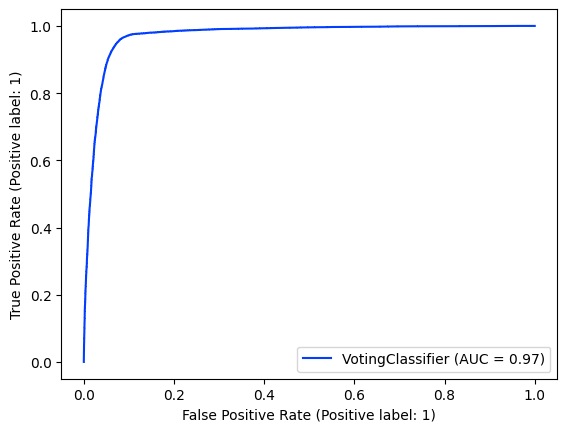

In [115]:
RocCurveDisplay.from_estimator(voting, X_test, y_test)

## VotingClassifier (Lgbm, Cat, XGboost)

In [217]:
voting = VotingClassifier(estimators=[('xgb', xgb), ('lgbm', lgbm_clf), ('cbc', pipe_cbc)], voting='soft')

In [218]:
voting.fit(X_train, y_train)

VotingClassifier(estimators=[('xgb',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('xgbclassifier',
                                               XGBClassifier(alpha=0.5252170103074075,
                                                             base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=0.7366486650079365,
                                                             device=None,
                                                             early_stopping_rounds=None,
                                                             enable_categorical=False,
                                                             eval_metric='auc'...
                                                              n_jobs=-1,
                                                              num_leaves=32,
                                                              objective='binary',
                                                              random_state=42,
                                                              reg_alpha=2.9837880825088554,
                                                              reg_lambda=1.2749689670536513,
                                                              scale_pos_weight=2.322854548999615,
                                                              subsample=0.6195074612443567,
                                                              verbose=-1))])),
                             ('cbc',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('catboostclassifier',
                                               <catboost.core.CatBoostClassifier object at 0x0000021E0816C2D0>)]))],
                 voting='soft')

## Save Result

In [199]:
def save_result(model, test, name):
    test_pred = model.predict_proba(test)[:, 1]
    ser_pred = pd.Series(test_pred, name='Exited')
    ser_pred[ser_pred == True] = 1
    ser_pred[ser_pred == False] = 0
    res = pd.DataFrame(data=[test.index, ser_pred]).transpose()
    res.columns = ['id', 'Exited']
    res['id'] = res.id.astype('int64')
    res.to_csv(name, index=False)  

In [437]:
save_result(xgbc, test, 'xgbc.csv')

In [367]:
save_result(pipe_xgboost, test, 'random_xgboost.csv')

In [331]:
save_result(lgbm, test, 'lgbm.csv')

In [444]:
save_result(pipe_lgbmc, test, 'pipe_grid_lgbmc.csv')

In [129]:
save_result(lgbm_clf, test, 'lgbm_clf.csv')

In [122]:
save_result(voting_clf, test, 'voting_clf.csv')

In [219]:
save_result(voting, test, 'voting.csv')